In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import jaxgptoolbox as jgp
import polyscope as ps
from plotnine import *
import polars as pl
import itertools
import sklearn
import ripser
import persim

ERROR:2025-03-27 21:45:33,938:jax._src.xla_bridge:647: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/irregular/Documents/SIGBOVIK/sigbovik/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 645, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/irregular/Documents/SIGBOVIK/sigbovik/.venv/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 103, in initialize
    triton.register_compilation_handler(
AttributeError: module 'jax._src.lib.triton' has no attribute 'register_compilation_handler'


In [3]:
v, f = jgp.read_mesh("../SPRING_FEMALE/SPRING0014.obj")

In [4]:
NUM_VERTICES = v.shape[0]
NUM_VERTICES

12500

In [4]:
v.shape

(12500, 3)

In [5]:
key = jax.random.PRNGKey(seed=42)

permutation = np.array(jax.random.permutation(key, NUM_VERTICES))
permutation

array([10278, 11527,  2836, ..., 10548,  1240,  9655], dtype=int32)

In [6]:
def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])

down_sampled = v[permutation[0:1000]]
down_sampled.shape

(1000, 3)

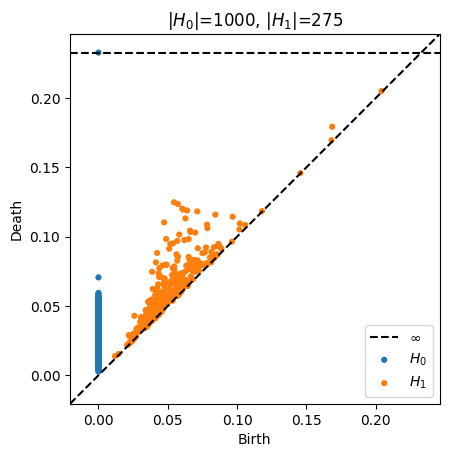

In [7]:

dgm = ripser.ripser(down_sampled)['dgms']
persim.plot_diagrams(
    dgm,
    show=True,
    title=diagram_sizes(dgm)
)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


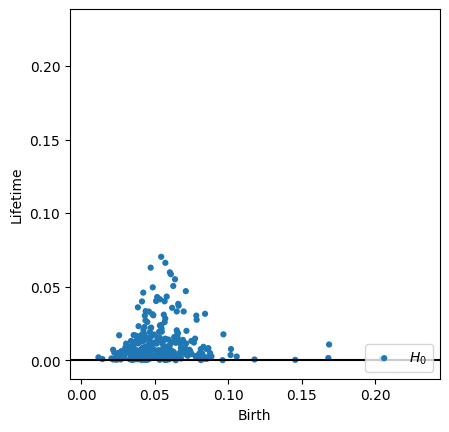

In [8]:
rips = ripser.Rips(maxdim=1)

dgm_h1 = rips.fit_transform(down_sampled)[1]

rips.plot(dgm_h1, lifetime=True)

PI resolution: (39, 15)


<Axes: xlabel='birth', ylabel='persistence'>

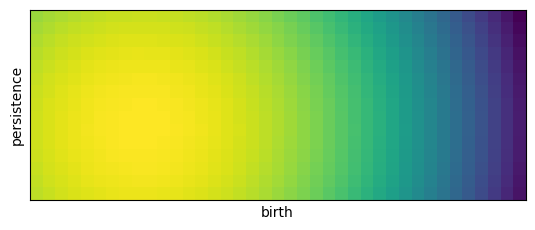

In [9]:
pimgr = persim.PersistenceImager(pixel_size=0.005)

pimgr.fit(dgm_h1)

print(f"PI resolution: {pimgr.resolution}")

img = pimgr.transform(dgm_h1)

pimgr.plot_image(img)

In [22]:
angle_defect = jgp.angle_defect(v,f)
vertex_area = jgp.vertex_areas(v,f)


In [23]:
np.sum(angle_defect), np.min(angle_defect), np.max(angle_defect)

(Array(0.0024128, dtype=float32),
 Array(-5.3018413, dtype=float32),
 Array(3.365827, dtype=float32))

In [7]:
curvature_standardized = (angle_defect - np.mean(angle_defect)) / np.std(angle_defect)

In [24]:
def clamp(x):
    p05 = np.percentile(x, 5)
    p95 = np.percentile(x, 95)
    return np.clip(x, p05, p95)

In [8]:
curvature_clamped = clamp(curvature)

/home/irregular/Documents/SIGBOVIK/sigbovik/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 4669'. Pick better value with 'binwidth'.


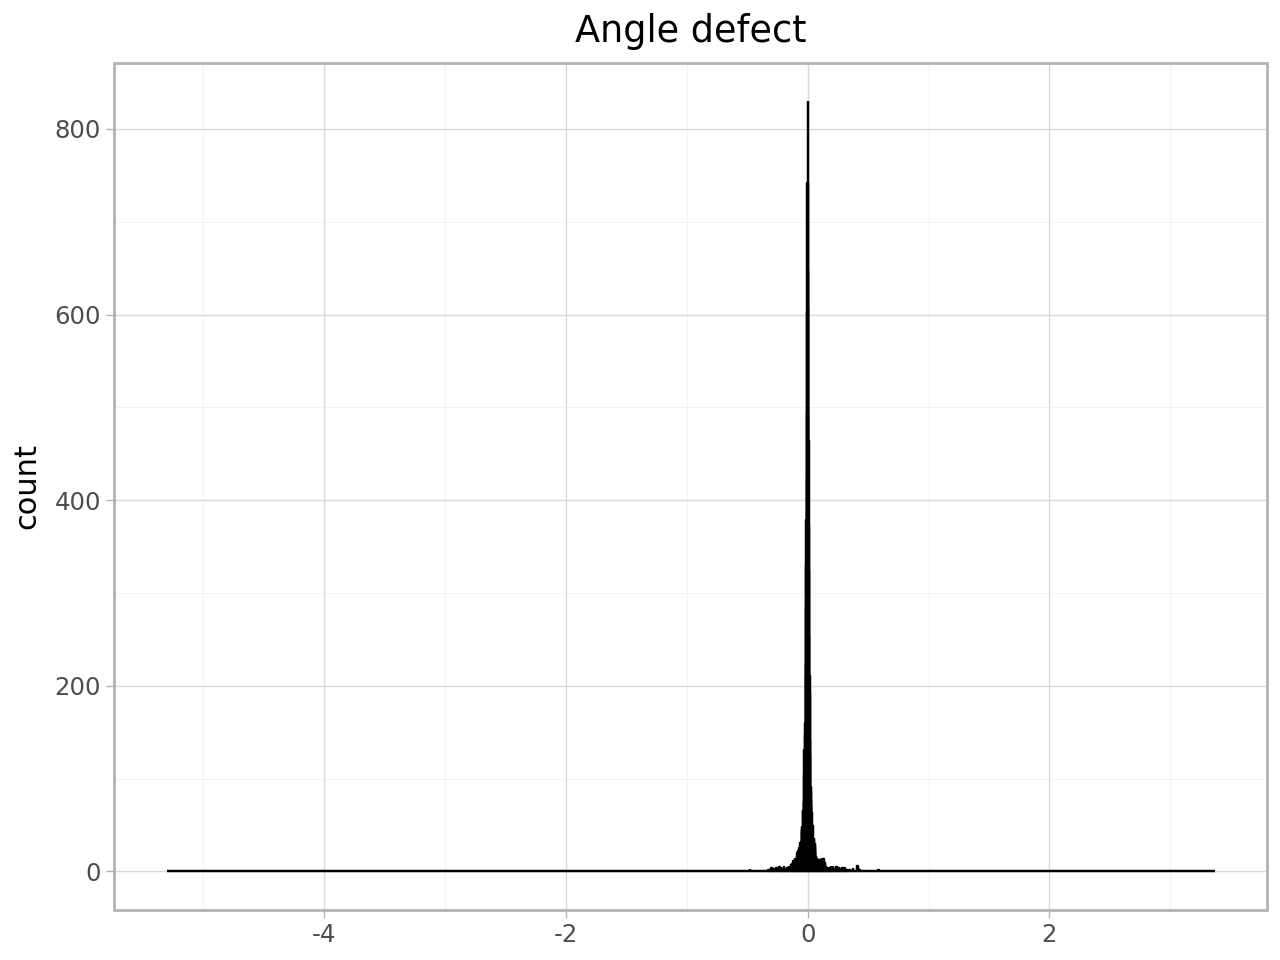

In [24]:
(ggplot() +
geom_histogram(aes(x=angle_defect), fill='steelblue', color='black') +
labs(title='Angle defect') +
#scale_y_log10() +
theme_light()
)


In [19]:
ps.init()
f_mesh = ps.register_surface_mesh('female', v, f)
f_mesh.add_scalar_quantity('angle defect', curvature_clamped)
f_mesh.add_scalar_quantity('vertex area', vertex_area)
ps.show()

In [8]:
def smooth_mesh(v, f):
    A = jgp.adjacency_vertex_vertex(f)
    d = np.sum(A, axis=1) + 1.0
    v_n = A @ v
    return (v + v_n) / d

In [11]:
smooth_v = smooth_mesh(v,f)
smooth_v = smooth_mesh(smooth_v, f)
smoothed_curvature = jgp.angle_defect(smooth_v, f)

In [12]:
np.sum(smoothed_curvature), np.min(smoothed_curvature), np.max(smoothed_curvature)

(Array(0.00237751, dtype=float32),
 Array(-3.1294103, dtype=float32),
 Array(1.6755657, dtype=float32))

/home/irregular/Documents/SIGBOVIK/sigbovik/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 3681'. Pick better value with 'binwidth'.


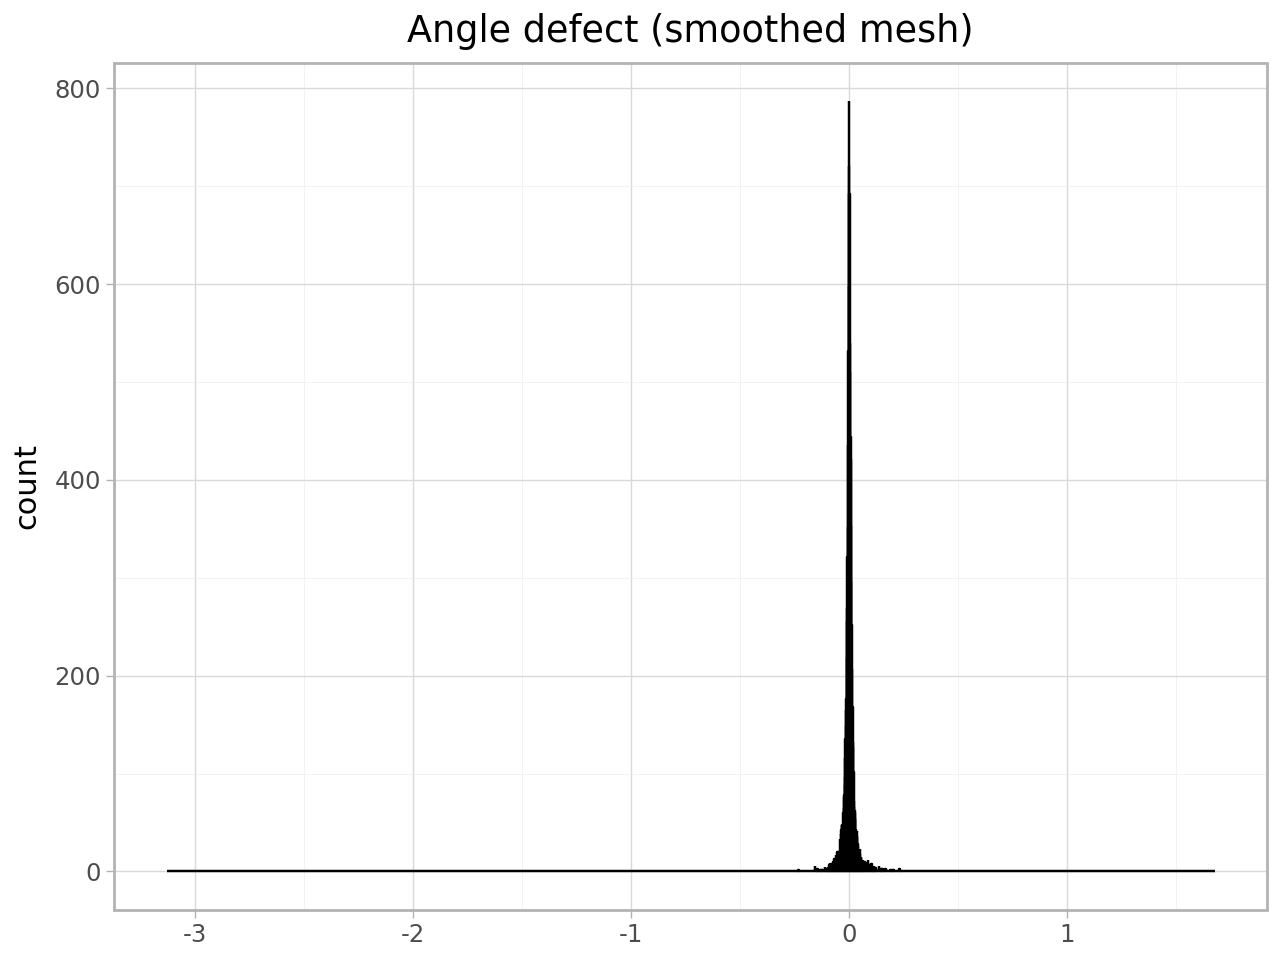

In [19]:
(ggplot() +
geom_histogram(aes(x=smoothed_curvature), fill='steelblue', color='black') +
labs(title='Angle defect (smoothed mesh)') +
theme_light()
)

In [20]:
ps.init()
smoothed_mesh = ps.register_surface_mesh('smoothed mesh', smooth_v, f)
smoothed_mesh.add_scalar_quantity('angle defect', smoothed_curvature)
ps.show()

In [9]:
def get_smoothed_angle_defect(v, f):
    v_smooth = smooth_mesh(v, f)
    v_smooth = smooth_mesh(v_smooth, f) # smooth twice
    angle_defect = jgp.angle_defect(v_smooth, f)
    return angle_defect


In [ ]:
from pathlib import Path
import glob

num_vertices = 12500

female_path = Path('../SPRING_FEMALE')
male_path = Path('../SPRING_MALE')

female_files = list(female_path.glob("*.obj"))
male_files = list(male_path.glob("*.obj"))

ids = []
gender = []
angle_defect_matrix = []

for file_path in female_files:
    vertices, faces = jgp.read_mesh(str(file_path))
    filename = file_path.name
    mesh_id = filename[6:].split('.')[0]

    gender.append('F')
    ids.append(f"F{mesh_id}")

    angle_defect = get_smoothed_angle_defect(vertices, faces)
    angle_defect_matrix.append(angle_defect)
    
for file_path in male_files:
    vertices, faces = jgp.read_mesh(str(file_path))
    filename = file_path.name
    mesh_id = filename[6:].split('.')[0]

    gender.append('M')
    ids.append(f"M{mesh_id}")

    angle_defect = get_smoothed_angle_defect(vertices, faces)
    angle_defect_matrix.append(angle_defect)


ShapeError: data does not match the number of columns

In [ ]:

df_meta = pl.DataFrame({
    "id": ids,
    "gender": gender
})
colnames = [f"ad_v_{i}" for i in range(num_vertices)]
df_angle_defect = pl.DataFrame(np.vstack(angle_defect_matrix), schema=colnames)

In [13]:
from pathlib import Path
import glob

female_path = Path('../SPRING_FEMALE')
male_path = Path('../SPRING_MALE')

female_files = list(female_path.glob("*.obj"))
male_files = list(male_path.glob("*.obj"))

ids = []
gender = []
data_matrix = []

for file_path in female_files:
    vertices, faces = jgp.read_mesh(str(file_path))
    filename = file_path.name
    mesh_id = filename[6:].split('.')[0]

    gender.append('F')
    ids.append(f"F{mesh_id}")

    v_smooth = smooth_mesh(v, f)
    v_smooth = smooth_mesh(v_smooth, f) # smooth twice

    coords = v_smooth.flatten()
    
    data_matrix.append(coords)
    
for file_path in male_files:
    vertices, faces = jgp.read_mesh(str(file_path))
    filename = file_path.name
    mesh_id = filename[6:].split('.')[0]

    gender.append('M')
    ids.append(f"M{mesh_id}")

    v_smooth = smooth_mesh(v, f)
    v_smooth = smooth_mesh(v_smooth, f) # smooth twice

    coords = v_smooth.flatten()
    
    data_matrix.append(coords)


In [16]:

df_meta = pl.DataFrame({
    "id": ids,
    "gender": gender
})
nested = [[f"v_{i}_x",f"v_{i}_y",f"v_{i}_z"] for i in range(NUM_VERTICES)]
colnames = list(itertools.chain(*nested))
df_data = pl.DataFrame(np.vstack(data_matrix), schema=colnames)

In [25]:
df_meta

id,gender
str,str
"""F1994""","""F"""
"""F4668""","""F"""
"""F4761""","""F"""
"""F1207""","""F"""
"""F0189""","""F"""
…,…
"""M0660""","""M"""
"""M2847""","""M"""
"""M4367""","""M"""


In [5]:

key = jax.random.PRNGKey(seed=42)

permutation = np.array(jax.random.permutation(key, NUM_VERTICES))
permutation

n_downsample = 1000
rips = ripser.Rips(maxdim=1)
pimgr = persim.PersistenceImager(pixel_size=0.005)

df = pl.read_csv("coords_smoothed.csv")
data_matrix = df.select(df.columns[2:37502]).to_numpy()

down_sampled_coords = []

for row in data_matrix:
    v = row.reshape(NUM_VERTICES,3)
    v_downsampled = v[permutation[0:n_downsample]]
    down_sampled_coords.append(v_downsampled)
    
    


Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [6]:
diagrams = [rips.fit_transform(vs)[1] for vs in down_sampled_coords]


In [8]:
pimgr.fit(diagrams)
imgs = pimgr.transform(diagrams)

persistence_matrix = np.array([img.flatten() for img in imgs])

In [10]:
persistence_matrix.shape

(3048, 465)

In [13]:
df_meta = df[:,[0,1]]
colnames = [f"p_{i}" for i in range(465)]
df_persistence = pl.DataFrame(persistence_matrix, schema=colnames)
df_persistence

p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,p_12,p_13,p_14,p_15,p_16,p_17,p_18,p_19,p_20,p_21,p_22,p_23,p_24,p_25,p_26,p_27,p_28,p_29,p_30,p_31,p_32,p_33,p_34,p_35,p_36,…,p_428,p_429,p_430,p_431,p_432,p_433,p_434,p_435,p_436,p_437,p_438,p_439,p_440,p_441,p_442,p_443,p_444,p_445,p_446,p_447,p_448,p_449,p_450,p_451,p_452,p_453,p_454,p_455,p_456,p_457,p_458,p_459,p_460,p_461,p_462,p_463,p_464
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,…,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,…,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,…,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,…,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,…,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012

In [15]:
df = pl.concat([df_meta, df_persistence], how="horizontal")
df.write_csv("data/persistence_smoothed.csv")

In [17]:
df_data

v_0_x,v_0_y,v_0_z,v_1_x,v_1_y,v_1_z,v_2_x,v_2_y,v_2_z,v_3_x,v_3_y,v_3_z,v_4_x,v_4_y,v_4_z,v_5_x,v_5_y,v_5_z,v_6_x,v_6_y,v_6_z,v_7_x,v_7_y,v_7_z,v_8_x,v_8_y,v_8_z,v_9_x,v_9_y,v_9_z,v_10_x,v_10_y,v_10_z,v_11_x,v_11_y,v_11_z,v_12_x,…,v_12487_z,v_12488_x,v_12488_y,v_12488_z,v_12489_x,v_12489_y,v_12489_z,v_12490_x,v_12490_y,v_12490_z,v_12491_x,v_12491_y,v_12491_z,v_12492_x,v_12492_y,v_12492_z,v_12493_x,v_12493_y,v_12493_z,v_12494_x,v_12494_y,v_12494_z,v_12495_x,v_12495_y,v_12495_z,v_12496_x,v_12496_y,v_12496_z,v_12497_x,v_12497_y,v_12497_z,v_12498_x,v_12498_y,v_12498_z,v_12499_x,v_12499_y,v_12499_z
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
-0.027136,0.185153,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.200099,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,-0.990261,-0.060228,…,-0.280607,0.149354,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.147254,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
-0.027136,0.185153,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.200099,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,-0.990261,-0.060228,…,-0.280607,0.149354,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.147254,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
-0.027136,0.185153,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.200099,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,-0.990261,-0.060228,…,-0.280607,0.149354,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.147254,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
-0.027136,0.185153,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.200099,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,-0.990261,-0.060228,…,-0.280607,0.149354,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.147254,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
-0.027136,0.185153,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.200099,-0.989053,-0.054

In [18]:
df = pl.concat([df_meta, df_data], how="horizontal")

In [ ]:


df = pl.read_csv("coords_smoothed.csv")
data_matrix = df.select(df.columns[2:37502]).to_numpy()

spectrum_matrix = []

for row in data_matrix:
    v = row.reshape(NUM_VERTICES,3)
    v_downsampled = v[permutation[0:n_downsample]]
    down_sampled_coords.append(v_downsampled)
    
    

In [19]:
df.write_csv("coords_smoothed.csv")

In [33]:
df = pl.read_csv("coords_smoothed.csv")

In [34]:
df

id,gender,v_0_x,v_0_y,v_0_z,v_1_x,v_1_y,v_1_z,v_2_x,v_2_y,v_2_z,v_3_x,v_3_y,v_3_z,v_4_x,v_4_y,v_4_z,v_5_x,v_5_y,v_5_z,v_6_x,v_6_y,v_6_z,v_7_x,v_7_y,v_7_z,v_8_x,v_8_y,v_8_z,v_9_x,v_9_y,v_9_z,v_10_x,v_10_y,v_10_z,v_11_x,v_11_y,…,v_12487_z,v_12488_x,v_12488_y,v_12488_z,v_12489_x,v_12489_y,v_12489_z,v_12490_x,v_12490_y,v_12490_z,v_12491_x,v_12491_y,v_12491_z,v_12492_x,v_12492_y,v_12492_z,v_12493_x,v_12493_y,v_12493_z,v_12494_x,v_12494_y,v_12494_z,v_12495_x,v_12495_y,v_12495_z,v_12496_x,v_12496_y,v_12496_z,v_12497_x,v_12497_y,v_12497_z,v_12498_x,v_12498_y,v_12498_z,v_12499_x,v_12499_y,v_12499_z
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""F1994""","""F""",-0.027136,0.1851528,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.2000988,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,…,-0.280607,0.1493539,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.1472541,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
"""F4668""","""F""",-0.027136,0.1851528,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.2000988,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,…,-0.280607,0.1493539,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.1472541,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
"""F4761""","""F""",-0.027136,0.1851528,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.2000988,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,…,-0.280607,0.1493539,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.1472541,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
"""F1207""","""F""",-0.027136,0.1851528,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0.030164,0.2000988,-0.989053,-0.054845,0.172102,-0.993878,-0.051291,0.192335,…,-0.280607,0.1493539,0.147871,-0.285177,0.162779,0.148808,-0.273566,0.061485,0.064668,-0.281098,0.070359,0.069008,-0.284098,0.080666,0.080428,-0.287025,0.092241,0.08526,-0.289527,0.158764,0.152544,-0.275878,0.155234,0.1472541,-0.278976,0.144618,0.137044,-0.286217,0.124298,0.107236,-0.293621,0.115651,0.109368,-0.291489,0.157608,0.141561,-0.278668
"""F0189""","""F""",-0.027136,0.1851528,-0.993163,-0.019469,0.173407,-0.99622,-0.009937,0.18924,-0.993429,-0.037553,0.16634,-0.995577,-0.044077,0.182807,-0.992691,-0.001918,0.177351,-0.996391,-0.008265,0.164383,-0.998507,-0.016012,0.198658,-0.990726,-0.020815,0.160086,-0.998243,-0

In [38]:
row = df[0,:]
row[2:37502]

id,gender,v_0_x,v_0_y,v_0_z,v_1_x,v_1_y,v_1_z,v_2_x,v_2_y,v_2_z,v_3_x,v_3_y,v_3_z,v_4_x,v_4_y,v_4_z,v_5_x,v_5_y,v_5_z,v_6_x,v_6_y,v_6_z,v_7_x,v_7_y,v_7_z,v_8_x,v_8_y,v_8_z,v_9_x,v_9_y,v_9_z,v_10_x,v_10_y,v_10_z,v_11_x,v_11_y,…,v_12487_z,v_12488_x,v_12488_y,v_12488_z,v_12489_x,v_12489_y,v_12489_z,v_12490_x,v_12490_y,v_12490_z,v_12491_x,v_12491_y,v_12491_z,v_12492_x,v_12492_y,v_12492_z,v_12493_x,v_12493_y,v_12493_z,v_12494_x,v_12494_y,v_12494_z,v_12495_x,v_12495_y,v_12495_z,v_12496_x,v_12496_y,v_12496_z,v_12497_x,v_12497_y,v_12497_z,v_12498_x,v_12498_y,v_12498_z,v_12499_x,v_12499_y,v_12499_z
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64


In [21]:
data_matrix = df.select(df.columns[2:37502]).to_numpy()

In [22]:
data_matrix.shape

(3048, 37500)

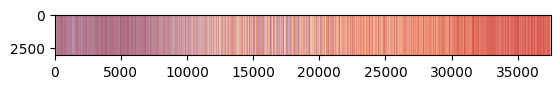

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(clamp(data_matrix), cmap='coolwarm')
plt.show()

In [38]:
mean_v = np.mean(data_matrix, axis=0).reshape(NUM_VERTICES,3)

In [41]:
jgp.write_obj("mean_human_body.obj", mean_v, f)

In [39]:
ps.init()
mean_mesh = ps.register_surface_mesh('mean human body', mean_v, f)
ps.show()

In [26]:
mesh_id = df[:,'id']
gender = df[:,'gender']

In [27]:
U, S, Vt = np.linalg.svd(data_matrix)

In [28]:
U.shape

(3048, 3048)

In [34]:
Vt.shape

(37500, 37500)

In [29]:
explained_variance = (S**2) / (S**2).sum()
cumulative_variance = np.cumsum(explained_variance)
component = np.arange(1,len(S)+1)

In [30]:
PC1 = U[:,0] * S[0]
PC2 = U[:,1] * S[1]
PC3 = U[:,2] * S[2]
PC4 = U[:,3] * S[3]

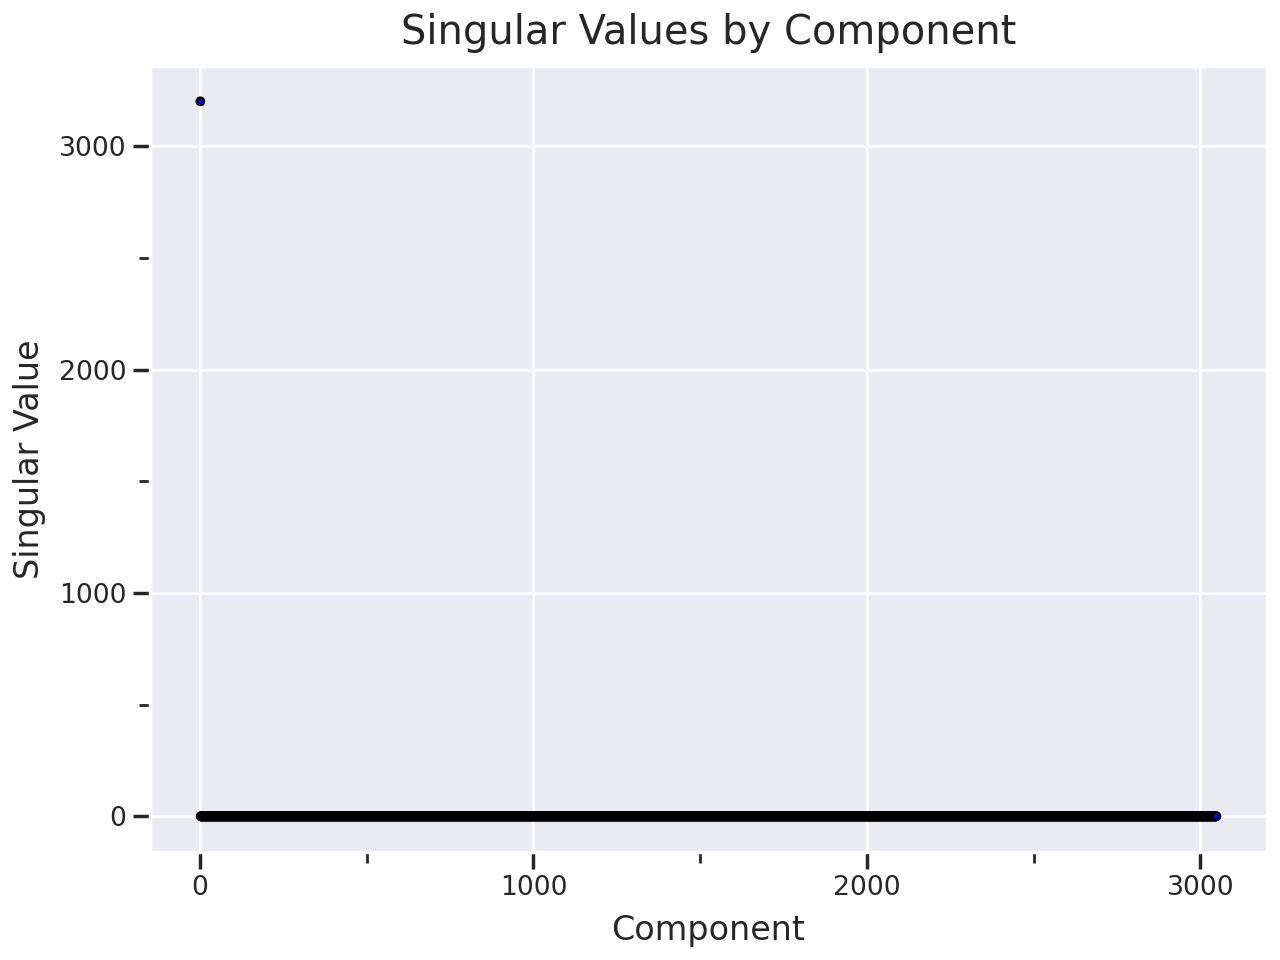

In [31]:
(
    ggplot() +
    geom_point(aes(x=component, y=S), fill='blue', size=1) +
    #geom_line(aes(x='Component', y='ExplainedVariance'), fill='blue') +
    labs(title='Singular Values by Component',
        x='Component',
        y = 'Singular Value'
    ) +
    theme_seaborn()
    #scale_x_continuous(breaks=range(1,min(21,len(S)+1), 2))
)

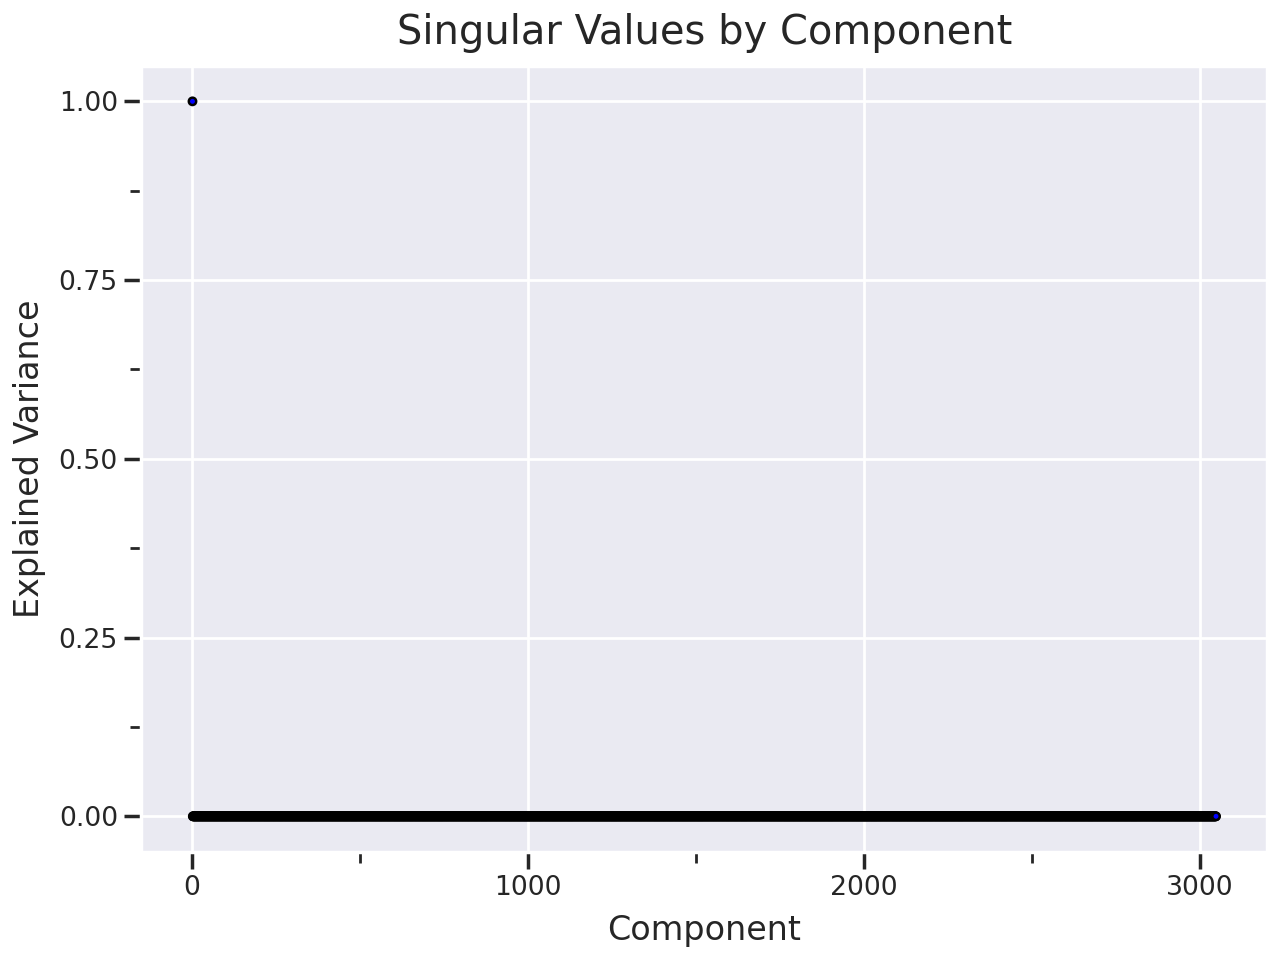

In [32]:
(
    ggplot() +
    geom_point(aes(x=component, y=explained_variance), fill='blue', size=1) +
    #geom_line(aes(x='Component', y='ExplainedVariance'), fill='blue') +
    labs(title='Singular Values by Component',
        x='Component',
        y = 'Explained Variance'
    ) +
    theme_seaborn()
    #scale_x_continuous(breaks=range(1,min(21,len(S)+1), 2))
)

/home/irregular/Documents/SIGBOVIK/sigbovik/.venv/lib/python3.10/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


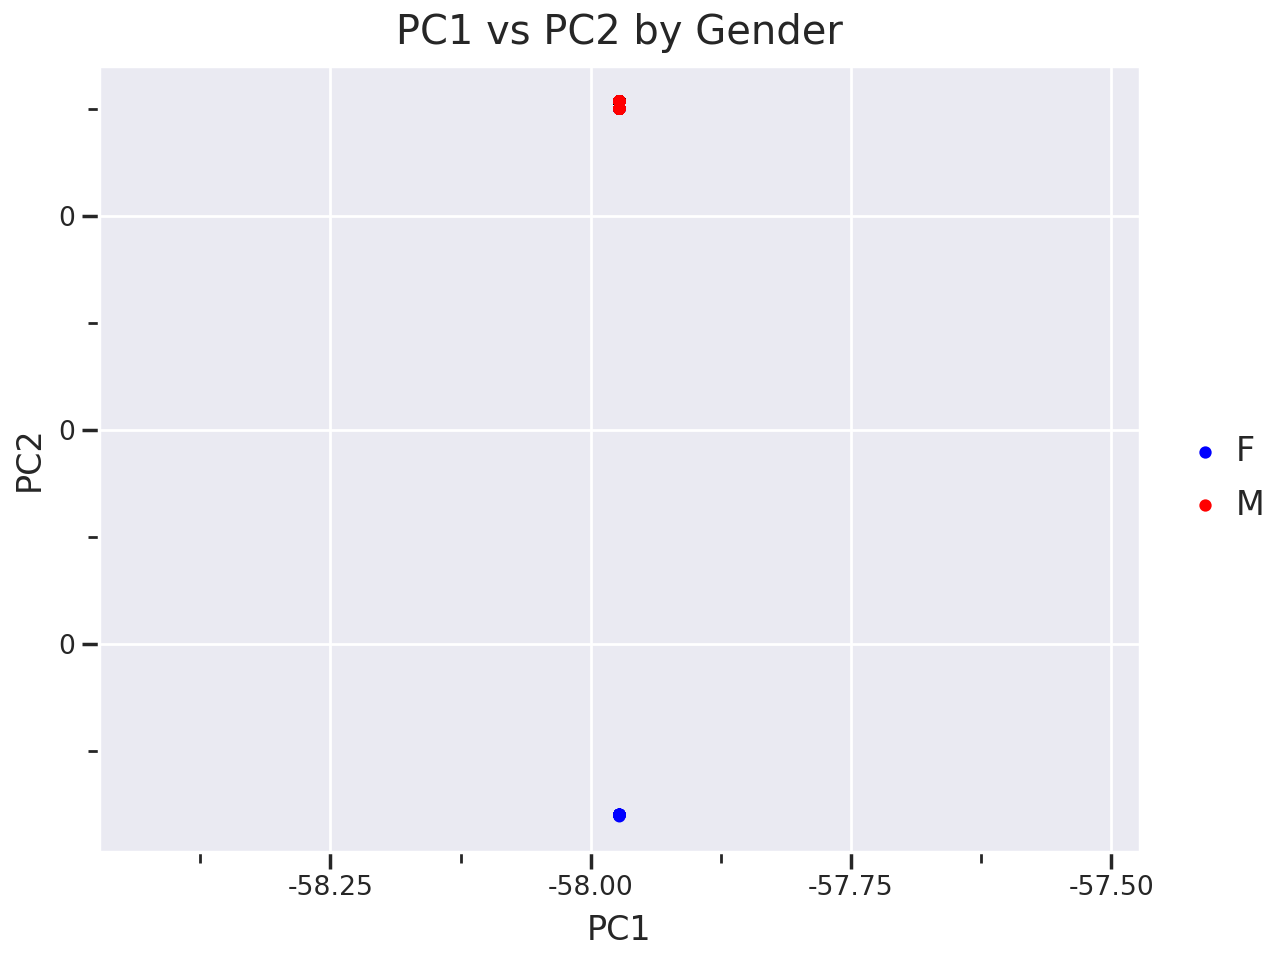

In [33]:
(
    ggplot() +
    geom_point(aes(x=PC1,y=PC2, color=gender)) +
    labs(title="PC1 vs PC2 by Gender",
        x = 'PC1',
        y = 'PC2'
    ) +
    theme_seaborn() +
    scale_color_manual(values=['blue','red'])
)

/home/irregular/Documents/SIGBOVIK/sigbovik/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 56'. Pick better value with 'binwidth'.


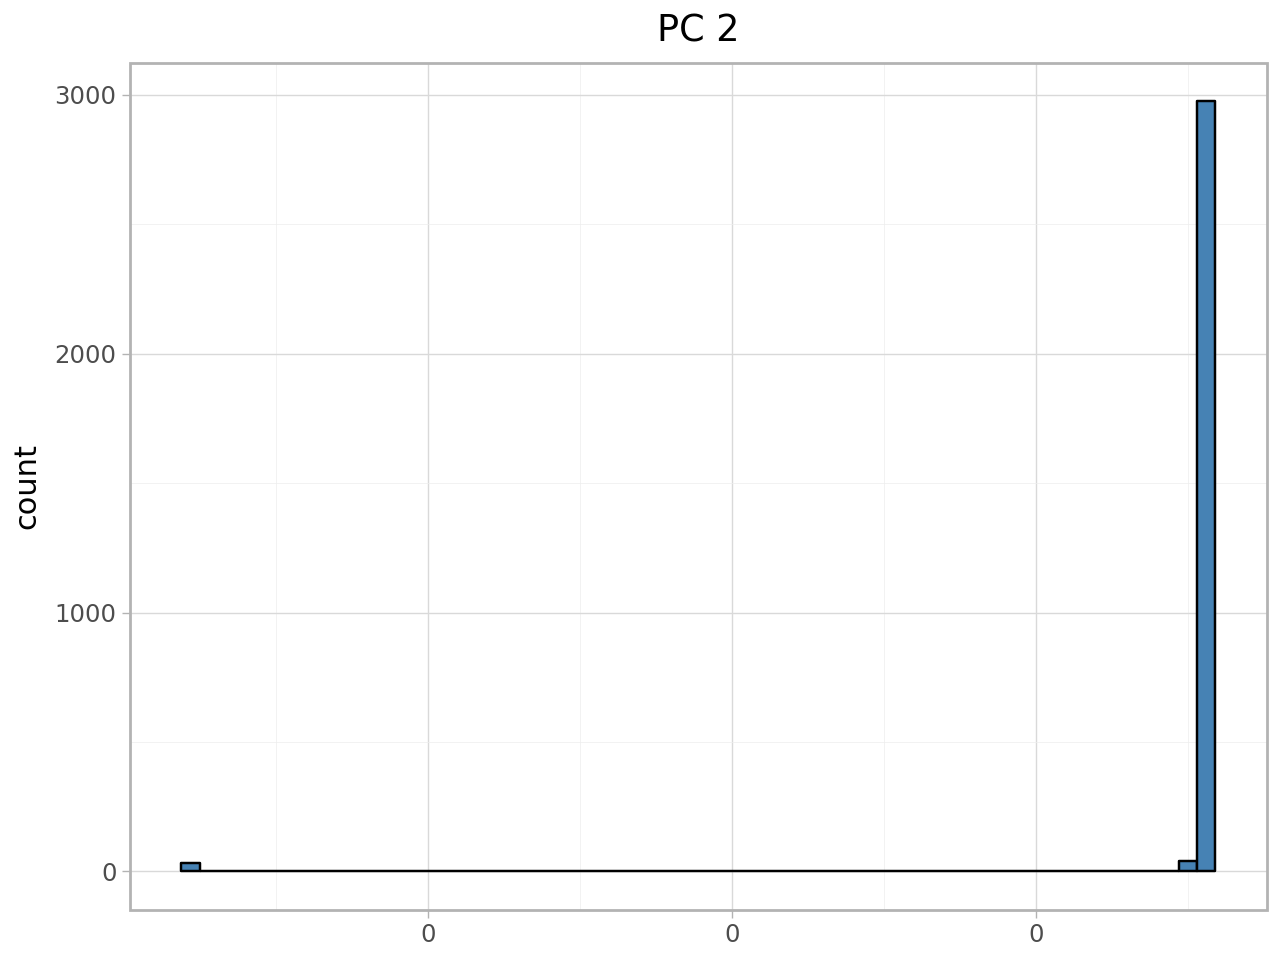

In [42]:
(ggplot() +
geom_histogram(aes(x=PC2), fill='steelblue', color='black') +
labs(title='PC 2') +
theme_light()
)